<a href="https://colab.research.google.com/github/maulana-tech/My-Project-DataAnalyst/blob/main/Demand_Foreasting_Inventory_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.tsa.statespace.sarimax as sarimax

data = pd.read_csv("demand_inventory.csv")
print(data.head())


   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


There's an unnamed column in the dataset. Drop it and move foward:

In [3]:
fig_demand = px.line(data, x='Date',
                     y='Demand',
                     title='Demand Over Time')
fig_demand.show()

Visualize the Inventory over Timme

In [4]:
fig_inventory = px.line(data, x='Date',
                        y='Inventory',
                        title='Inventory Over Time')
fig_inventory.show()

# Demand Forecasting:
I can see seasonal patterns in the demand. We can forecast the demand using SARIMA. Let’s first calculate the value of p and q using ACF and PACF plots:

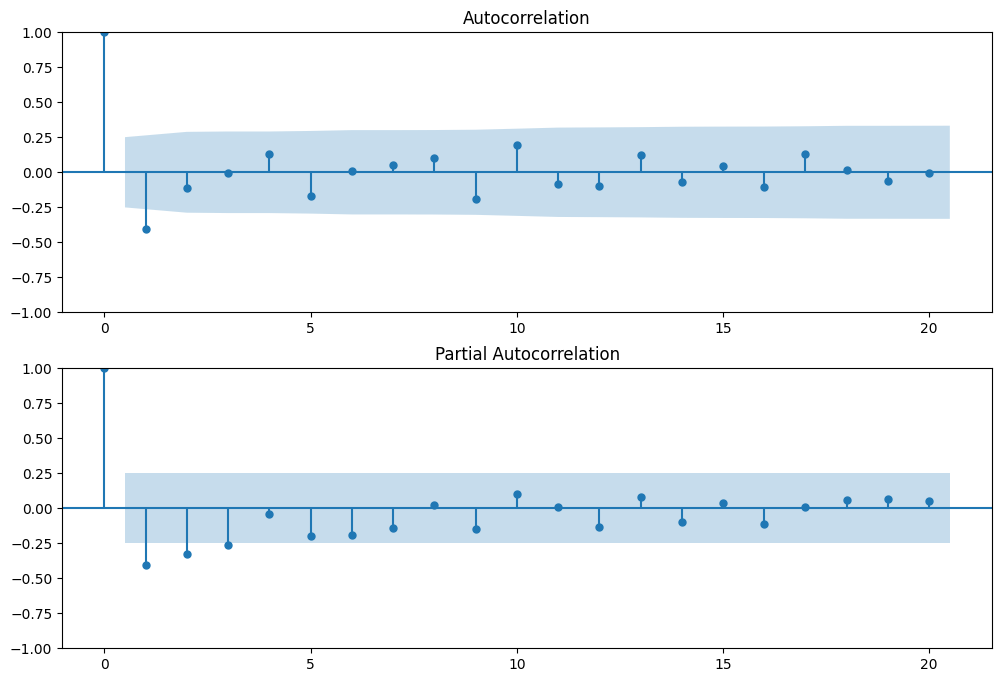

In [9]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Set 'Date' as the index and extract the 'Demand' column
time_series = data.set_index('Date')['Demand']

# Compute the first difference of the time series and drop NaN values
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of the differenced time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(differenced_series, ax=axes[0], lags=20)
plot_pacf(differenced_series, ax=axes[1], lags=20)
plt.show()

In [12]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2)
model = sarimax.SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
preditions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
print(preditions)

2023-08-02    117.116352
2023-08-03    116.815049
2023-08-04    130.939605
2023-08-05    114.949909
2023-08-06    128.937954
2023-08-07    115.346713
2023-08-08    129.351664
2023-08-09    115.387844
2023-08-10    129.390110
2023-08-11    115.484079
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



# Invenntory Optimization
 optimize inventory according to the foresacted demand for the next ten days:

In [14]:
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(preditions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory)
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 237
Reorder Point: 236.50039858034899
Safety Stock: 115.128470678168
Total Cost: 561.85


1. Optimal Order Quantity: 236 – The optimal order quantity refers to the quantity of a product that should be ordered from suppliers when the inventory level reaches a certain point. In this case, an optimal order quantity of 236 units has been calculated.
2. Reorder Point: 235.25 – The reorder point is the inventory level at which a new order should be placed to replenish stock before it runs out. In this case, a reorder point of 235.25 units has been calculated, which means that when the inventory reaches or falls below this level, an order should be placed to replenish stock.
3. Safety Stock: 114.45 – Safety stock is the additional inventory kept on hand to account for uncertainties in demand and supply. It acts as a buffer against unexpected variations in demand or lead time. In this case, a safety stock of 114.45 units has been calculated, which helps ensure that there’s enough inventory to cover potential fluctuations in demand or lead time.
4. Total Cost: 561.80 – The total cost represents the combined costs associated with inventory management. In this case, the total cost has been calculated as approximately 561.80 units based on the order quantity, reorder point, safety stock, and associated costs.

By analyzing these values, you can make informed decisions about how much inventory to order and when to place orders to ensure a smooth supply chain and customer satisfaction while minimizing costs.

# Summary
So this is how you can perform Demand Forecasting and Inventory Optimization using Python. Demand Forecasting involves predicting the quantity and pattern of customer orders, which is crucial for businesses to efficiently allocate resources, manage inventory, and plan production. Inventory Optimization aims to strike a balance between having sufficient stock to meet demand without carrying excess inventory that ties up capital and storage space. I hope you liked this article on Demand Forecasting and Inventory Optimization using Python. Feel free to ask valuable questions in the comments section below.